In [12]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [13]:
import math

class ImagePlot:
    def __init__(self, max_columns=5):
        self.reset()
        self.max_columns = max_columns

    def reset(self):
        self.images = []

    def add(self, image, title=""):
        self.images.append({
            "image": image,
            "title": title
        })

    def show(self):
        n_rows = math.ceil(len(self.images) / self.max_columns)
        n_cols = self.max_columns

        plt.figure(figsize=(25, 7))
        for i in range(len(self.images)):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(self.images[i]["image"], cmap="gray")
            plt.title(self.images[i]["title"])
            plt.axis("off")

        plt.show()

plotter = ImagePlot()

In [14]:
dataset = scipy.io.loadmat("./data/mnist-original.mat")

In [15]:
X = dataset["data"]
Y = dataset["label"]

print(X.shape)
print(Y.shape)

(784, 70000)
(1, 70000)


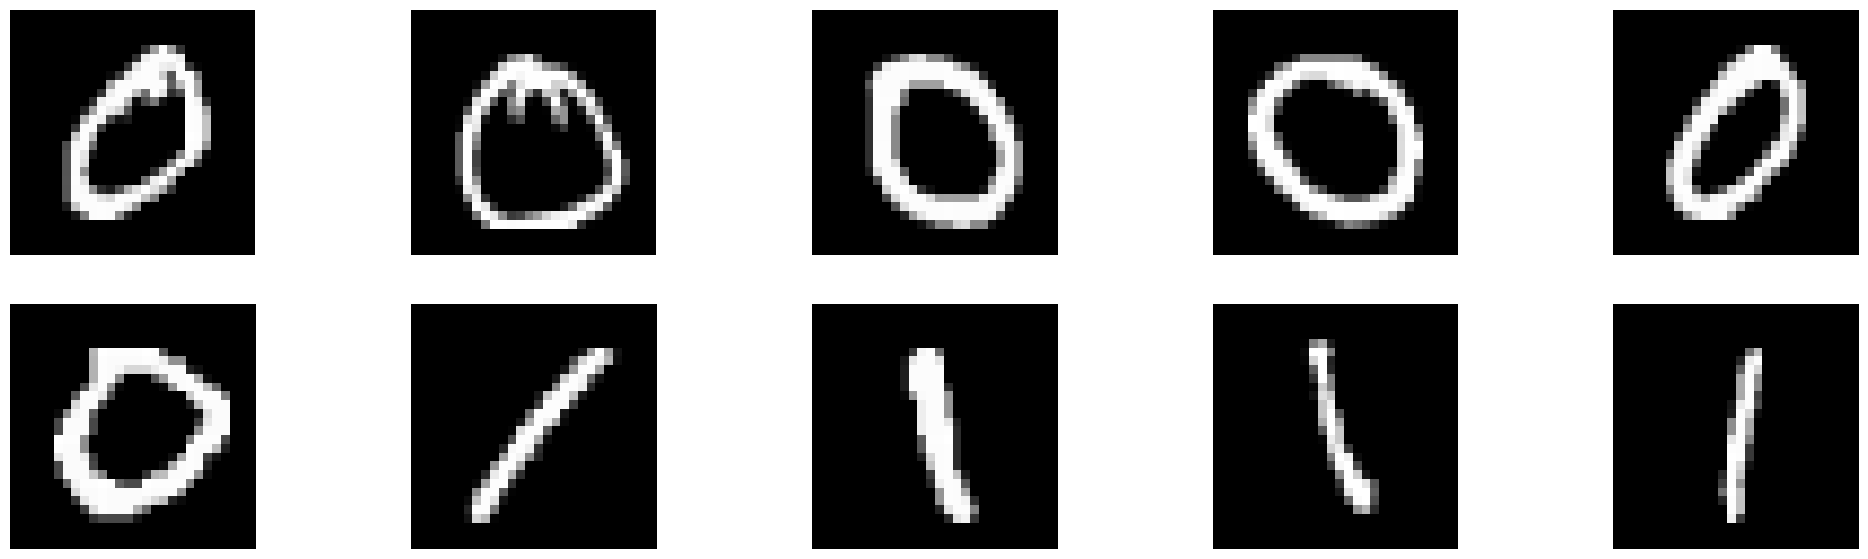

In [16]:
plotter.reset()

for i in range(0, 10000, 1000):
    plotter.add(X[:, i].reshape((28, 28)))

plotter.show()

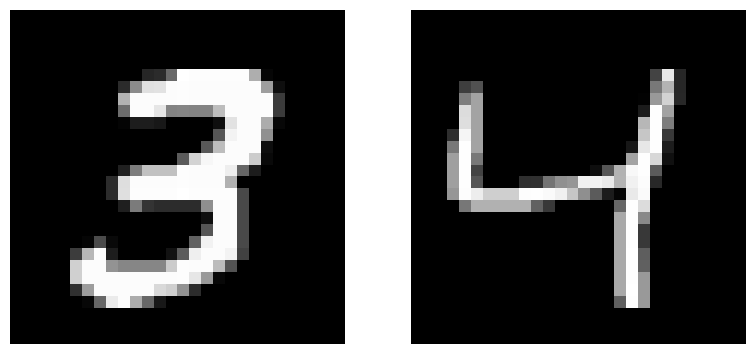

In [25]:
c1 = 3
c2 = 4
X_c1 = X[:, (Y == c1).flatten()]
X_c2 = X[:, (Y == c2).flatten()]

plotter.reset()
plotter.add(X_c1[:, 0].reshape((28, 28)))
plotter.add(X_c2[:, 0].reshape((28, 28)))
plotter.show()

In [26]:
X_c1_train = X_c1[:, :int(X_c1.shape[1]*0.8)]
X_c1_test = X_c1[:, :int(X_c1.shape[1]*0.2)]

X_c2_train = X_c2[:, :int(X_c2.shape[1]*0.8)]
X_c2_test = X_c2[:, :int(X_c2.shape[1]*0.2)]

print(f"X_c1 | train: {X_c1_train.shape} -- test: {X_c1_test.shape}")
print(f"X_c2 | train: {X_c2_train.shape} -- test: {X_c2_test.shape}")

X_c1 | train: (784, 5712) -- test: (784, 1428)
X_c2 | train: (784, 5459) -- test: (784, 1364)


In [27]:
U1, _, _ = np.linalg.svd(X_c1_train, full_matrices=False)
U2, _, _ = np.linalg.svd(X_c2_train, full_matrices=False)

In [28]:
def predict(digit):
    y1_proj = U1 @ (U1.T @ digit)
    y2_proj = U2 @ (U2.T @ digit)

    dist1 = np.linalg.norm(digit - y1_proj, 2)
    dist2 = np.linalg.norm(digit - y2_proj, 2)

    if dist1 < dist2:
        return c1
    else:
        return c2

def evaluate(dataset, true_label):
    correct = 0

    for i in range(dataset.shape[1]):
        if predict(dataset[:, i]) == true_label:
            correct += 1

    return correct

c1_correct = evaluate(X_c1_test, c1)
c2_correct = evaluate(X_c2_test, c2)

print(f"Accuracy: {c1_correct / X_c1_test.shape[1]:.3f} ({X_c1_test.shape[1]-c1_correct} wrong)")
print(f"Accuracy: {c2_correct / X_c2_test.shape[1]:.3f} ({X_c2_test.shape[1]-c2_correct} wrong)")

Accuracy: 0.962 (54 wrong)
Accuracy: 0.468 (726 wrong)
